In [1]:
from functools import partial
from math import sqrt
from pathlib import Path
import geopandas as gpd
from itertools import product
import time
import timeit
import csv

In [2]:
input_dir = Path('vector_1000')
output_dir = Path.cwd()

# Get a list of all GPKG files in the folder
v_files = list(sorted(input_dir.glob('*.gpkg')))

In [3]:
# Specify the number of files to open
num_files_to_open = 100
bench_runs=30  #Benchmark runs, should probably do 30 

In [4]:
# Loop through each GPKG file and join
for i, file in enumerate(v_files[:num_files_to_open]):
    col_name = file.stem.split('_')[1]  # Extracting the column name from the file name
    df = gpd.read_file(file)
    df.columns = [col_name, *df.columns[1:]] #Setting the column to the file
    if i == 0:
        combined_df = df.copy()
    else:
        combined_df = gpd.overlay(combined_df, df)

Benchmarking for joining

In [5]:
joining_time = []
def run_loop(num_files_to_open, v_files):
    
    join_time= []
    start_time = time.time()
    for i, file in enumerate(v_files[:num_files_to_open]):
        col_name = file.stem.split('_')[1]  # Extracting the column name from the file name
        df = gpd.read_file(file)
        df.columns = [col_name, *df.columns[1:]] #Setting the column to the file

        #Joining benchmark
        join_Stime=time.time()
        if i == 0:
            combined_df = df.copy()
        else:
            combined_df = gpd.overlay(combined_df, df) 
        join_Etime=time.time()
        join_Ftime = join_Etime - join_Stime
        join_time.append(join_Ftime)
        
    end_time = time.time()
    
    # Calculate and print the time taken for each run
    time_taken = end_time - start_time
    joining_time.append(sum(join_time))
    print(f'Run: Joining time- {sum(join_time)} , Total Time taken - {time_taken} seconds')

In [6]:
timeit.timeit(lambda: run_loop(num_files_to_open, v_files), number=bench_runs) #Benchmark run for joining

Run: Joining time- 498.81545209884644 , Total Time taken - 500.10979104042053 seconds
Run: Joining time- 389.31525444984436 , Total Time taken - 390.4242248535156 seconds
Run: Joining time- 380.4957320690155 , Total Time taken - 381.62742805480957 seconds
Run: Joining time- 422.7017865180969 , Total Time taken - 423.81195044517517 seconds
Run: Joining time- 377.97346210479736 , Total Time taken - 379.30134415626526 seconds
Run: Joining time- 476.466970205307 , Total Time taken - 477.77076292037964 seconds
Run: Joining time- 382.31259322166443 , Total Time taken - 383.45258498191833 seconds
Run: Joining time- 455.3882119655609 , Total Time taken - 456.60805344581604 seconds
Run: Joining time- 398.1823036670685 , Total Time taken - 399.2033221721649 seconds
Run: Joining time- 408.78109645843506 , Total Time taken - 409.94284534454346 seconds
Run: Joining time- 383.26140999794006 , Total Time taken - 387.82810521125793 seconds
Run: Joining time- 402.33724784851074 , Total Time taken - 403

12224.767833500053

Defining classes

In [7]:
def is_prime(n):
    count = 0
    if n > 1:
        for i in range(1, n + 1):
            if n % i == 0:
                count += 1
    return count == 2

def is_polygonal(s, x):
    assert s > 2 and s % 1 == 0 and x % 1 == 0
    n = (sqrt(8 * (s - 2) * x + (s - 4) ** 2) + (s - 4)) / (2 * (s - 2))
    return n % 1 == 0

def is_fibonacci(n):
    a, b = 0,1
    while a < n:
        a, b = b, a + b
    return a == n

def is_perfect(n):
    sum = 1
    i = 2
    while i * i <= n:
        if n % i == 0:
            sum = sum + i + n/i
        i += 1
    return sum == n and n != 1

In [8]:
combined_df['sum'] = combined_df.select_dtypes(include='number').sum(axis=1)
classes = [
    ('is_prime', is_prime),
    ('is_triangular', partial(is_polygonal, 3)),
    ('is_rectangular', partial(is_polygonal, 4)),
    ('is_pentagonal', partial(is_polygonal, 5)),
    ('is_hexagonal', partial(is_polygonal, 6)),
    ('is_fibonacci', is_fibonacci),
    ('is_perfect', is_perfect),
]
for i, func in enumerate(classes):
    combined_df[func[0]] = combined_df['sum'].apply(func[1])

In [9]:
numerics = list(combined_df.select_dtypes(include='number'))
combined_df = combined_df.drop(columns=numerics)

In [10]:
combinations = list(product([True, False], repeat=7))
class_mapping = {tuple(row): f'Class_{i+1:03}' for i, row in enumerate(combinations)}

Benchmarking Classification

In [11]:
classify_time=[]
def classify_loop():
    
    start_time = time.time()

    bench_class = combined_df[['is_prime','is_triangular','is_rectangular','is_pentagonal','is_hexagonal','is_fibonacci','is_perfect']].apply(lambda row: class_mapping[tuple(row.astype(int))], axis=1) #This should remain the same, as cell count remains static   

    end_time = time.time()
    
    # Calculate and print the time taken for each run
    time_taken = end_time - start_time
    classify_time.append(time_taken)
    print(f'Run: Time taken - {time_taken} seconds')

In [12]:
timeit.timeit(lambda: classify_loop(), number=bench_runs) #Benchmark run for classifying

Run: Time taken - 7.617931365966797 seconds
Run: Time taken - 8.285682439804077 seconds
Run: Time taken - 7.4368507862091064 seconds
Run: Time taken - 7.760572671890259 seconds
Run: Time taken - 7.720075845718384 seconds
Run: Time taken - 8.587639331817627 seconds
Run: Time taken - 9.120808601379395 seconds
Run: Time taken - 9.041035413742065 seconds
Run: Time taken - 8.256629943847656 seconds
Run: Time taken - 9.2949800491333 seconds
Run: Time taken - 8.959702253341675 seconds
Run: Time taken - 9.10095763206482 seconds
Run: Time taken - 9.10010051727295 seconds
Run: Time taken - 9.061169624328613 seconds
Run: Time taken - 9.138447046279907 seconds
Run: Time taken - 9.663845777511597 seconds
Run: Time taken - 9.906778812408447 seconds
Run: Time taken - 9.699655294418335 seconds
Run: Time taken - 9.670398235321045 seconds
Run: Time taken - 10.27969241142273 seconds
Run: Time taken - 9.94239854812622 seconds
Run: Time taken - 9.610458612442017 seconds
Run: Time taken - 10.07102370262146 

275.3047806000104

Writing benchmark results

In [13]:
with open(f'Vector_benchmark_{num_files_to_open}_layers.csv', 'w', newline='') as csvfile: #Writing benchmark results
    writer = csv.writer(csvfile)
    writer.writerow(['Run', 'Joining(s)','Classify(s)'])
    for i, (join_taken, classify_taken) in enumerate(zip(joining_time, classify_time)):
        writer.writerow([i+1, join_taken, classify_taken])

Applying classification

In [14]:
combined_df['class'] = combined_df[['is_prime','is_triangular','is_rectangular','is_pentagonal','is_hexagonal','is_fibonacci','is_perfect']].apply(lambda row: class_mapping[tuple(row.astype(int))], axis=1)
combined_df=combined_df[['class','geometry']]

In [15]:
output_dir.mkdir(parents=True, exist_ok=True)
output = (output_dir / f'Vector_{num_files_to_open}_layers.gpkg')
# output.touch(exist_ok=True)
combined_df.to_file(output, layer='benchmarking', driver='GPKG', mode='w')

<Axes: >

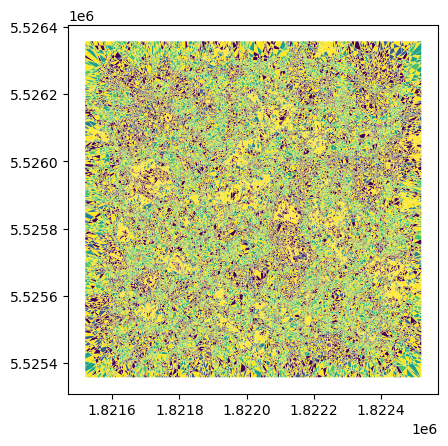

In [16]:
combined_df.plot('class', cmap='viridis')